In [1]:
import sagemaker
import uuid

In [2]:
sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

SageMaker version: 2.74.0


In [3]:
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/eva7-s15-cifar100'
role = sagemaker.get_execution_role()

In [4]:
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

In [5]:
print('Checkpointing Path: {}'.format(checkpoint_s3_path))
print(f'Role is {role}')
print(f'Bucket is {bucket}')

Checkpointing Path: s3://sagemaker-us-east-2-363027134642/checkpoint-2b7725c7
Role is arn:aws:iam::363027134642:role/service-role/AmazonSageMaker-ExecutionRole-20220224T091857
Bucket is sagemaker-us-east-2-363027134642


In [6]:
import os
import subprocess

In [7]:
instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'

print("Instance Type = " + instance_type)

Instance Type = local


In [8]:
!pip install pytorch-lightning --quiet

In [9]:
# Generic Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, re
from skimage import io

# Pytorch related Imports
import torchvision, torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import OneCycleLR # we are not going to use as we are only running 4 epochs

# lightning related imports
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from pytorch_lightning import seed_everything  # Global Seeding
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping # not used because we are running only 4 epochs
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, ModelSummary

In [10]:
from utils_cifar100 import CIFAR100DataModule, unpickle, imshow
from source_dir import cifar100

In [11]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=10, verbose=False, mode="min"
)

MODEL_CKPT_PATH = "./resnet34_model/"
MODEL_CKPT = "resnet34-{epoch:02d}-{val_loss:.2f}"

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=MODEL_CKPT_PATH,
    filename=MODEL_CKPT,
    save_top_k=3,
    mode="min",
)

In [12]:
# Init our data pipeline
dm = CIFAR100DataModule(batch_size=64)

In [13]:
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [14]:
dm.setup()

In [15]:
trainloader = dm.train_dataloader()
testloader = dm.test_dataloader()

In [16]:
metaData = unpickle("./data/cifar-100-python/meta")

label_names = metaData["fine_label_names"]
print(len(label_names))

100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing label names of first 8 train images
84 table
0 apple
95 whale
92 tulip
22 clock
71 sea
20 chair
36 hamster


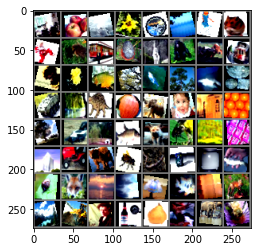

In [17]:
# get some random training images
trainiter = iter(trainloader)
img_train, lbl_train = trainiter.next()

# show images
imshow(torchvision.utils.make_grid(img_train))
labels_list = lbl_train.tolist()
print("Showing label names of first 8 train images")
for i in range(8):
    print(labels_list[i], label_names[labels_list[i]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Showing label names of first 8 test images
49 mountain
33 forest
72 seal
51 mushroom
71 sea
92 tulip
15 camel
14 butterfly


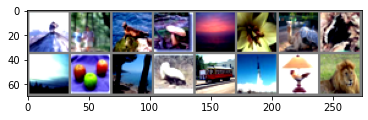

In [18]:
# get some random test images
testiter = iter(testloader)
img_test, lbl_test = testiter.next()

# show images
imshow(torchvision.utils.make_grid(img_test))
labels_list = lbl_test.tolist()
print("Showing label names of first 8 test images")
for i in range(8):
    print(labels_list[i], label_names[labels_list[i]])

In [19]:
inputs = sagemaker_session.upload_data(
    path="data", bucket=bucket, key_prefix="data/cifar100-python"
)

In [20]:
from sagemaker.pytorch import PyTorch

In [21]:
use_spot_instances = True
max_run = 600
max_wait = 1200 if use_spot_instances else None

In [22]:
hyperparameters = {"batch_size": 64, "checkpoint-path": checkpoint_s3_path}

In [23]:
checkpoint_local_path = "/opt/ml/checkpoints"

In [24]:
cifar100_estimator = PyTorch(
    entry_point="source_dir/cifar100.py",
    role=role,
    framework_version="1.7.1",
    py_version="py3",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.p3.8xlarge",
    base_job_name="cifar100-Feb24-v0-spot",
    checkpoints_s3_uri=checkpoint_s3_path,
    checkpoint_local_path=checkpoint_local_path,
    debugger_hook_config=False,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
)

In [25]:
cifar100_estimator.fit(inputs)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.8xlarge for spot training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

In [ ]:
from sagemaker.pytorch import PyTorchModel

In [ ]:
predictor = cifar100_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

In [ ]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.size())

labels_list = labels.tolist()

In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join("%4s" % label_names[labels_list[j]] for j in range(4)))

In [ ]:
outputs = predictor.predict(images.numpy())

In [ ]:
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

In [ ]:
print("Predicted: ", " ".join("%4s" % label_names[predicted[j]] for j in range(4)))

In [ ]:
# predictor.delete_endpoint()  #Very Important !!!